In [1]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg

In [2]:
eps_0 = 8.854187813e-12

eps_r = 8.854187813e-12 # might also be an input vector (1D) or matrix/tensor (2D/3D)

Na = 9 # length of 1D "grids"

k_B = 1.38064852e-23 # m^2 kg s^-2 K^-1
k_B = 1.38064852e-23 * 1e30 # m^2 kg fs^-2 K^-1

In [3]:
# global variables

a = 1/(Na - 1)

A_x = np.arange(0, 1 + 1e-15, a)
B_x = np.arange(a/2, 1 + a/2 + 1e-15, a)


The shape of B is (10, 10)

B is 
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
The difference is: [-3.84467512e-04  0.00000000e+00 -8.67361738e-19 -4.33680869e-19
 -4.33680869e-19 -4.33680869e-19 -4.33680869e-19 -4.33680869e-19
  0.00000000e+00 -3.84467512e-04]
[0.         0.00153787 0.00269127 0.00346021 0.00384468 0.00384468
 0.00346021 0.00269127 0.00153787 0.        ]
[0.00038447 0.00153787 0.00269127 0.00346021 0.00384468 0.00384468
 0.00346021 0.00269127 0.00153787 0.00038447]


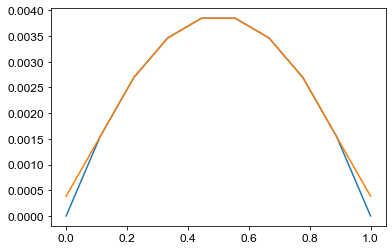

In [231]:
def B_construct_1D(Na, ghosts_included = True):
    """
    Input: Na (int), number of grid points
           ghosts_included (bool), default is True (B is (Na-2) x (Na-2) and rho is Na-2)
                                           if False (B is (Na) x (Na) and rho is Na)
    Output: B (float array), 1D Poisson discretization matrix
    """
    # construct the tridiagonal Poisson discretization matrix B
   
    if (ghosts_included):
        
        offsets = [-1, 0, 1] 
        diags = []
        diags.append(-np.ones(Na-3)) 
        diags.append(2 * np.ones(Na-2))
        diags.append(-np.ones(Na-3))
        B = scipy.sparse.diags(diags, offsets, format='csr') # construct a CSR version of B
        B = B.toarray() # this function will only be called once so CSR not too important
        #print('The shape of B is', np.shape(B))
        #print('\nB is \n', B)      
        
    else:
        
        offsets = [-1, 0, 1] 
        diags = []
        
        diags.append(-np.ones(Na-3)) 
        diags.append(2 * np.ones(Na-2))
        diags.append(-np.ones(Na-3))
        B = scipy.sparse.diags(diags, offsets, format='csr') # construct a CSR version of B
        B = B.toarray() # this function will only be called once so CSR not too important
        B = np.pad(B, [1, 1], mode='constant')
        B[0][0] = 1
        B[np.shape(B)[0]-1][np.shape(B)[0]-1] = 1
        print('The shape of B is', np.shape(B))
        print('\nB is \n', B)

    return B
    
    
def rho_update_1D(Na, n_alpha, q_alpha):
    """
    Input: Na (int), number of grid points
           n_alpha (float array), (Na + 1) x (alpha) where each column vector represents 
               n values for one alpha
           q_alpha (int array), each entry represents charge of a species
    Output: rho (float array), charge density array
    """
    
    # TREATING n_alpha as an Na x alpha matrix and q_alpha as an alpha x 1 column vector
    # ==> rho = n_alpha @ q_alpha is then the Na x 1 charge density column vector
    rho = n_alpha @ q_alpha
 
    return rho
   
    
def phi_update_1D(Na, B_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1): 
    # epsilon_0 and epsilon_r expected to be global variables with possibility of epsilon_r(x) vector 
    """
    Input: Na (int), number of grid points
           B_matrix (float array), 1D Poisson discretization matrix
           rho (float array), (Na + 1) x 1 vector
           ghosts_included = True default
           epsilon_0 & epsilon_r (float) constants
    Output: phi (float array), charge density array
    """
    
    if (ghosts_included):
        
        rho_vec = rho[1:-1] # remove boundaries/ghosts
        phi_soln = scipy.sparse.linalg.cg(B_matrix, rho_vec)[0]
        phi = np.insert(phi_soln, 0, 0)   # add left boundary/ghost
        phi = np.insert(phi, len(phi), 0) # add right boundary/ghost
        
    else:
        
        #rho = np.insert(rho, 0, 0)
        #rho = np.insert(rho, len(rho), 0)
        #print(len(rho))
        
        phi = scipy.sparse.linalg.cg(B_matrix, rho)[0]
        
        #rho = rho[1:-1]
        #phi = phi[1:-1]
        
    La = 1
    X = np.linspace(0, La, Na)

    plt.plot(X, phi)
      
    return phi
                                                            

    
#########
# TESTS #
#########
    
    
Ne = 10
n_al = np.transpose([[0, 1, 2, 1, 0], [0, 1, 2, 1, 0]])
ch = [-1, 3]


Bmatrix = B_construct_1D(Ne)

Bma = B_construct_1D(Ne, False) 

phiphi = a**2 * np.ones(Ne)

#phiphi = [-1, 0, 1, 0, -1, 0, 1, 0, -1, 0]
#phiphi = [-1, 0, 1, 0, -1, 0, 1, 0, -1, 0, -1, 0, 1, 0, -1, 0, 1, 0, -1, 0]

#phiphi = [-1, 2, 8, 4, 10, -5, 3, 6, 91, 10]

abc = phi_update_1D(Ne, Bmatrix, phiphi)

bcd = phi_update_1D(Ne, Bma, phiphi, False)

#rho_update_1D(Ne, (n_al), ch)

print('The difference is:', abc - bcd)
print(abc)
print(bcd)

## Note:

Since the updates for $\mu_\alpha$ and $v_\alpha$ rely on values which are independent from each other, a combined function utilizing 1 instead of 2 separate for loops would be better. 

<br>

COMBINE `mu_alpha_update_1D` and `v_alpha_update_1D` into one function and return both values, then call as

`mu_alpha, v_alpha = mu_and_v_alpha_update_1D(Na, mu_bar_alpha, q_alpha, phi, D_alpha)`

In [5]:
def mu_alpha_update_1D(Na, mu_bar_alpha, q_alpha, phi):
    """
    Input: Na (int), number of grid points
           mu_bar_alpha (float array), (Na + 1) x (alpha) where each column vector represents 
               mu values for one alpha
           q_alpha (int array), each entry represents charge of a species
           phi (float array)
    Output: mu_alpha (float array), mobility array
    """
    # each mu column vector, mu_1, is given by mu_bar_1 + q_alpha_1 * phi, hence:
    
    # initialize J_alpha
    mu_alpha = np.zeros((np.shape(mu_bar_alpha)[0], np.shape(mu_bar_alpha)[1]))
    
    for i in range(len(q_alpha)): # loop over column vectors
        
        mu_alpha[:,i] = mu_bar_alpha[:,0] + q_alpha[i] * phi  # LOOK AGAIN
          
    return mu_alpha


def v_alpha_update_1D(Na, D_alpha):
    """
    Input: Na (int), number of grid points
           D_alpha (float array), (Na + 1) x (alpha) where each column vector represents 
               D values for one alpha
           q_alpha (int array), each entry represents charge of a species
           phi (float array)
    Output: mu_alpha (float array), mobility array
    """
    
    a = 1/(Na - 1) # calculate dx
    
    # initialize J_alpha
    v_alpha = np.zeros((np.shape(D_alpha)[0], np.shape(D_alpha)[1]))
    
    for i in range(np.shape(D_alpha)[1]): # loop over column vectors
        
        v_alpha[:,i] = (1/a) * D_alpha[:,i]   
    
    return v_alpha


def J_alpha_update_1D(Na, T, mu_alpha, v_alpha, n_alpha):
    """
    Input: Na (int), number of grid points
           T (float), temperature
           mu_alpha (float array), (Na + 1) x (alpha) 
           v_alpha (float array), (Na + 1) x (alpha) 
           n_alpha (float array), (Na + 1) x (alpha) 
    Output: J_alpha (float array), particle current array
    """
    # Boltzmann's constant, ADD SOMETHING to handle different units
    k_B = 1e-2
    
    # initialize J_alpha
    J_alpha = np.zeros((np.shape(mu_alpha)[0], np.shape(mu_alpha)[1]))
    
    for i in range(np.shape(mu_alpha)[0]):
        
        for alpha in range(np.shape(mu_alpha)[1]):
            
            # if/else statements check for existence of neigbors
            if (i == 0):
                J_1 = 0.0
            else:
                J_1 = np.exp(-(mu_alpha[i][alpha] + mu_alpha[i-1][alpha]) / (2 * k_B * T)) * (v_alpha[i-1][alpha] * n_alpha[i-1][alpha] * np.exp(mu_alpha[i-1][alpha]/(k_B * T)) 
                                                                                              - v_alpha[i][alpha] * n_alpha[i][alpha] * np.exp(mu_alpha[i][alpha]/(k_B * T))) 
                # expression for left neighbor
            
            if (i == np.shape(mu_alpha)[0] - 1):
                J_2 = 0.0
            else:
                J_2 = np.exp(-(mu_alpha[i+1][alpha] + mu_alpha[i][alpha]) / (2 * k_B * T)) * (v_alpha[i][alpha] * n_alpha[i][alpha] * np.exp(mu_alpha[i][alpha]/(k_B * T)) 
                                                                                              - v_alpha[i+1][alpha] * n_alpha[i+1][alpha] * np.exp(mu_alpha[i+1][alpha]/(k_B * T)))
                # expression for right neighbor
            
            ###print('J_1 =', J_1, '\nJ_2 =', J_2)
            
            # update J_alpha
            J_alpha[i][alpha] = J_1 + J_2 # (I think its correct) or J_1 - J_2, look at the directionality
            
            # J_alpha(0) = 0, boundary condition
            if (i == 0): # can also do J_alpha[0, :] = 0
                J_alpha[i][alpha] = 0
    
    return J_alpha



In [6]:
# Computational Grid: . * . * . * . (A is ., B is *, A needs one more point to the right of B) 

In [7]:
Ne = 5
mu_al = np.array([[1, 0], [2, 1], [3, 2], [4, 3], [5, 3]])
v_al = np.array([[1, 0], [2, 1], [3, 2], [4, 3], [5, 3]])
D_al = np.array([[1, 0], [2, 1], [3, 2], [4, 3], [5, 3]])

T = 300

Jal = J_alpha_update_1D(Ne, T, mu_al, v_al, n_al)

print(mu_al)
print(Jal)

[[1 0]
 [2 1]
 [3 2]
 [4 3]
 [5 3]]
[[ 0.          0.        ]
 [-7.75791985 -5.06032034]
 [-5.04175033 -4.03711427]
 [ 3.7393756   2.84184566]
 [ 3.3859269   3.        ]]


## Note:

Do both `J_1` AND `J_2` become $0$ at the boundaries ???

<br>

$J_\alpha(0) = 0$, so is $J_\alpha(N_a) = 0$ ??? 

In [8]:
def n_alpha_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha):
    """
    Input: dt (float), time-step size
           Na (int), number of grid points
           n_alpha_Update (float array), (Na + 1) x (alpha) 
           n_alpha_Current (float array), (Na + 1) x (alpha)  
           n_alpha_Past (float array), (Na + 1) x (alpha) 
           J_alpha (float array), (Na + 1) x (alpha) 
    Output: n_alpha_Update (float array), (Na + 1) x (alpha) 
            n_alpha_Current (float array), (Na + 1) x (alpha)  
            n_alpha_Past (float array), (Na + 1) x (alpha) 
    """
    
    a = 1/(Na - 1) # calculate dx
    B_x = np.arange(a/2, 1 + a/2 + 1e-15, a) # create B_x
    
    # initialize n_alpha_Update
    n_alpha_Update = np.zeros((np.shape(J_alpha)[0], np.shape(J_alpha)[1]))
    
    for i in range(np.shape(J_alpha)[0]):
        
        for alpha in range(np.shape(J_alpha)[1]):
            
            # if/else statements check for existence of index [i+1]
            if (i >= len(B_x) - 1): # could also be ==> i == len(B_x) - 1
                
                n_alpha_Update[i][alpha] = n_alpha_Past[i][alpha] - (2 * dt / a) * (- J_alpha[i][alpha])
                                                                # J_alpha[i+1][alpha] = 0 (at the boundary)
            else:
                
                n_alpha_Update[i][alpha] = n_alpha_Past[i][alpha] - (2 * dt / a) * (J_alpha[i+1][alpha] - J_alpha[i][alpha])
    
    # boundary condition, IS THIS SAME FOR x_B,0 ?????
    n_alpha_Update[-1,:] = n_alpha_Past[-1,:] # can also use n_alpha_Current
    
    #print('\n', n_alpha_Update[:,0])
    #print('\n', n_alpha_Update[0,:], '\n')
    #print('n_pas1 =', np.transpose(n_alpha_Past))
    #print('n_cur1 =', np.transpose(n_alpha_Current))
    #print('n_upd1 =', np.transpose(n_alpha_Update))
    
    # update the n_alpha's appropriately in preparation for the next iteration
    n_alpha_Past = n_alpha_Current
    n_alpha_Current = n_alpha_Update
    
    #print('n_pas2 =', np.transpose(n_alpha_Past))
    #print('n_cur2 =', np.transpose(n_alpha_Current))
    #print('n_upd2 =', np.transpose(n_alpha_Update))
    
    return n_alpha_Update, n_alpha_Current, n_alpha_Past 


In [9]:
def n_alpha_0th_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha):
    """
    Input: dt (float), time-step size
           Na (int), number of grid points
           n_alpha_Update (float array), (Na + 1) x (alpha) 
           n_alpha_Current (float array), (Na + 1) x (alpha)  
           n_alpha_Past (float array), (Na + 1) x (alpha) 
           J_alpha (float array), (Na + 1) x (alpha) 
    Output: n_alpha_Update (float array), (Na + 1) x (alpha) 
            n_alpha_Current (float array), (Na + 1) x (alpha)  
            n_alpha_Past (float array), (Na + 1) x (alpha) 
    """
    
    a = 1/(Na - 1) # calculate dx
    B_x = np.arange(a/2, 1 + a/2 + 1e-15, a) # create B_x
    
    # initialize n_alpha_Update
    n_alpha_Update = np.zeros((np.shape(J_alpha)[0], np.shape(J_alpha)[1]))
    
    for i in range(np.shape(J_alpha)[0]):
        
        for alpha in range(np.shape(J_alpha)[1]):
            
            # if/else statements check for existence of index [i+1]
            if (i >= len(B_x) - 1): # could also be ==> i == len(B_x) - 1
                
                n_alpha_Update[i][alpha] = n_alpha_Current[i][alpha] - (dt / a) * (- J_alpha[i][alpha])
                                                                # J_alpha[i+1][alpha] = 0 (at the boundary)
            else:
                
                n_alpha_Update[i][alpha] = n_alpha_Current[i][alpha] - (dt / a) * (J_alpha[i+1][alpha] - J_alpha[i][alpha])
    
    # boundary condition, IS THIS SAME FOR x_B,0 ?????
    n_alpha_Update[-1,:] = n_alpha_Current[-1,:] # can also use n_alpha_Current
    
    #print('\n', n_alpha_Update[:,0])
    #print('\n', n_alpha_Update[0,:], '\n')
    #print('n_pas1 =', np.transpose(n_alpha_Past))
    #print('n_cur1 =', np.transpose(n_alpha_Current))
    #print('n_upd1 =', np.transpose(n_alpha_Update))
    
    # update the n_alpha's appropriately in preparation for the next iteration
    n_alpha_Past = n_alpha_Current
    n_alpha_Current = n_alpha_Update
    
    #print('n_pas2 =', np.transpose(n_alpha_Past))
    #print('n_cur2 =', np.transpose(n_alpha_Current))
    #print('n_upd2 =', np.transpose(n_alpha_Update))
    
    return n_alpha_Update, n_alpha_Current, n_alpha_Past


In [10]:
def iteration_1D(dt, i_glob, Na, T, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1):
# Don't know if all the input parameters are necessary...
    
    # update rho
    rho = rho_update_1D(Na, n_alpha_Current, q_alpha)
    
    # update phi
    phi = phi_update_1D(Na, B_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
    
    # COMBINE THESE FUNCTIONS
    # update mu_alpha
    mu_alpha = mu_alpha_update_1D(Na, mu_bar_alpha, q_alpha, phi)
    # update v_alpha
    v_alpha = v_alpha_update_1D(Na, D_alpha)
    
    # update J_alpha
    J_alpha = J_alpha_update_1D(Na, T, mu_alpha, v_alpha, n_alpha_Current)
    
    # update n_alpha
    if (i_glob == 0): # for 1st timestep
        n_alpha_Update, n_alpha_Current, n_alpha_Past = n_alpha_0th_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha)
        #print('n_up0 =', n_alpha_Update.transpose())
        #print('n_cu0 =', n_alpha_Current.transpose())
        #print('n_pa0 =', n_alpha_Past.transpose())
    else:             # for all other timesteps
        n_alpha_Update, n_alpha_Current, n_alpha_Past = n_alpha_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha)
        #print('n_up1 =', n_alpha_Update.transpose())
        #print('n_cu1 =', n_alpha_Current.transpose())
        #print('n_pa1 =', n_alpha_Past.transpose())
        
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

### no actual purpose below...

In [11]:
def simulation_1D(dt, tmax, Na, T, n_alpha_Update, n_alpha_Current, n_alpha_Past, plotting = False): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    
    a = 1/(Na - 1) # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a)
    
    # construct the Poisson 1D discretization matrix B
    B_matrix = B_construct_1D(Na, ghosts_included = True)
    
    
    while (i_glob < tmax):
        
        n_alpha_Update, n_alpha_Current, n_alpha_Past = iteration_1D(dt, i_glob, Na, T, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
        
        if (plotting):
                    
            plt.figure()
            #plt.plot(A_x, n_updated[:,0]) # placeholder
            plt.plot(A_x, n_alpha_Update)
            
        i_glob += dt
        
    if (plotting):
        
        plt.show()
    
    return 0

# WINNER BELOW

In [12]:
import pandas as pd
import numpy as np
from glob import glob
import re 
import math
from pathlib import Path 
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FuncAnimation 

In [13]:
def simulation_1D(dt, tmax, Na, T, n_alpha_Update, n_alpha_Current, n_alpha_Past, plotting = False): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    t_cur = 0  # global time counter
    
    a = 1/(Na - 1) # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a) # create A_x, our plotting x-axis
    
    # initialize 
    n_alpha_Update = np.zeros((len(A_x), 1))
    n_plotting = np.array([])
    
    # construct the Poisson 1D discretization matrix B
    B_matrix = B_construct_1D(Na, ghosts_included = True)
    
    # start plotting/animating
    fig = plt.figure() # initialize figure
    axis = plt.axes(xlim =(0, 1), ylim =(-2, 10)) # marking the x-axis and y-axis 
    line, = axis.plot([], [], lw = 3) # initializing a line variable 
    plt.close() # to not have a stray plot
    
    # data which the line will 
    # contain (x, y) 
    def init(): 
        line.set_data([], []) 
        return line, 
    
    def animate(i): 
        x = np.arange(0, 1 + 1e-15, a) # set the x axis to A_x
        
        if (i < int(tmax/dt)):
            
            n_plot = n_plot_matrix[i,:] # extract the i^th row for plotting
        
            line.set_data(x, n_plot) 
            
        else:
            
            return line,
      
        return line,
    
    
    while (t_cur < tmax):
        
        n_alpha_Update, n_alpha_Current, n_alpha_Past = iteration_1D(dt, i_glob, Na, T, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
        
        if (plotting):
            
            n_plotting = np.append(n_plotting, n_alpha_Update)
                     
        i_glob += 1
        t_cur += dt
        
    n_plot_matrix = n_plotting.reshape((int(tmax/dt), len(A_x))) # every row corresponds to N_alpha 
                                                                 # at a different time-step
    
    print(np.shape(n_plot_matrix))
    
    if (plotting):
        
        anim = FuncAnimation(fig, animate, init_func = init, frames = 200, interval = 20, blit = True)
        
        #return HTML(anim.to_jshtml())
        
        return anim
    
    else:
        
        print('\nSimulation completed!')
        
        return 0

In [14]:
Ne = 50
q_alpha = np.array([0])
n_alpha_Update = np.zeros((Ne,1))
n_alpha_Current = np.zeros((Ne,1))
n_alpha_Current[25] = 10
n_alpha_Past = np.zeros((Ne,1))
mu_bar_alpha = np.zeros((Ne,1)) #+ 1e-1
D_alpha = 1e-1 * np.ones((Ne,1))

a = 1/(Ne - 1)

print(a)

dt = 0.1 * a**2

print(dt)
print(int(1/dt))

0.02040816326530612
4.164931278633902e-05
24010


The shape of B is (48, 48)

B is 
 [[ 2. -1.  0. ...  0.  0.  0.]
 [-1.  2. -1. ...  0.  0.  0.]
 [ 0. -1.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -1.  0.]
 [ 0.  0.  0. ... -1.  2. -1.]
 [ 0.  0.  0. ...  0. -1.  2.]]
(24010, 50)


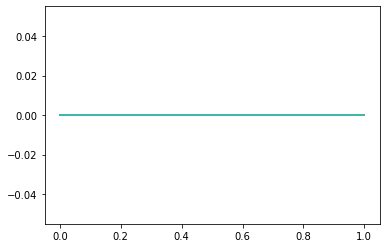

In [15]:
amez = simulation_1D(dt, 1, Ne, T, n_alpha_Update, n_alpha_Current, n_alpha_Past, plotting = True)

In [16]:
amez

# New Grid

The grid will start and end with $x_A$, with $x_B$'s in the middle. 

<br>

Grid A will have $N_a + 1$ points while grid B has $N_a$ points, where $x_A \in$ `np.arange(0, 1 + 1e-15, a)`

In [17]:
Na = 20

a = 1.0/Na # dx, now defined as 1/Na

A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na

print('Is length of A correct? :', np.allclose(len(A_x), Na + 1))
print('Is length of B correct? :', np.allclose(len(B_x), Na))


Is length of A correct? : True
Is length of B correct? : True


**Note :** Both $\rho$ and $\phi$ are placed on grid B, so they will have lengths of $N_a$. 

**Sidenote :** Therefore the functions in the cell below are the same as the ones implemented beforehand. 

The shape of B is (8, 8)
The shape of B is (10, 10)
The difference is: [-3.84467512e-04  0.00000000e+00 -8.67361738e-19 -4.33680869e-19
 -4.33680869e-19 -4.33680869e-19 -4.33680869e-19 -4.33680869e-19
  0.00000000e+00 -3.84467512e-04]
[0.         0.00153787 0.00269127 0.00346021 0.00384468 0.00384468
 0.00346021 0.00269127 0.00153787 0.        ]
[0.00038447 0.00153787 0.00269127 0.00346021 0.00384468 0.00384468
 0.00346021 0.00269127 0.00153787 0.00038447]


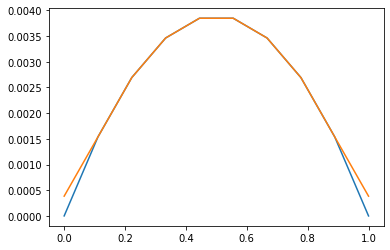

In [86]:
def B_construct_1D(Na, ghosts_included = True):
    """
    Input: Na (int), number of grid points
           ghosts_included (bool), default is True (B is (Na-2) x (Na-2) and rho is Na-2)
                                           if False (B is (Na) x (Na) and rho is Na)
    Output: B (float array), 1D Poisson discretization matrix
    """
    # construct the tridiagonal Poisson discretization matrix B
   
    if (ghosts_included):
        
        offsets = [-1, 0, 1] 
        diags = []
        diags.append(-np.ones(Na-3)) 
        diags.append(2 * np.ones(Na-2))
        diags.append(-np.ones(Na-3))
        B = scipy.sparse.diags(diags, offsets, format='csr') # construct a CSR version of B
        B = B.toarray() # this function will only be called once so CSR not too important
        print('The shape of B is', np.shape(B))
        #print('\nB is \n', B)      
        
    else:
        
        offsets = [-1, 0, 1] 
        diags = []
        
        diags.append(-np.ones(Na-3)) 
        diags.append(2 * np.ones(Na-2))
        diags.append(-np.ones(Na-3))
        B = scipy.sparse.diags(diags, offsets, format='csr') # construct a CSR version of B
        B = B.toarray() # this function will only be called once so CSR not too important
        B = np.pad(B, [1, 1], mode='constant')
        B[0][0] = 1
        B[np.shape(B)[0]-1][np.shape(B)[0]-1] = 1
        print('The shape of B is', np.shape(B))
        #print('\nB is \n', B)

    return B
    
    
def rho_update_1D(Na, n_alpha, q_alpha):
    """
    Input: Na (int), number of grid points
           n_alpha (float array), (Na + 1) x (alpha) where each column vector represents 
               n values for one alpha
           q_alpha (int array), each entry represents charge of a species
    Output: rho (float array), charge density array
    """
    
    # TREATING n_alpha as an Na x alpha matrix and q_alpha as an alpha x 1 column vector
    # ==> rho = n_alpha @ q_alpha is then the Na x 1 charge density column vector
    rho = n_alpha @ q_alpha
 
    return rho
   
    
def phi_update_1D(Na, B_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1): 
    # epsilon_0 and epsilon_r expected to be global variables with possibility of epsilon_r(x) vector 
    """
    Input: Na (int), number of grid points
           B_matrix (float array), 1D Poisson discretization matrix
           rho (float array), (Na + 1) x 1 vector
           ghosts_included = True default
           epsilon_0 & epsilon_r (float) constants
    Output: phi (float array), charge density array
    """
    
    if (ghosts_included):
        
        rho_vec = rho[1:-1] # remove boundaries/ghosts
        phi_soln = scipy.sparse.linalg.cg(B_matrix, rho_vec)[0]
        phi = np.insert(phi_soln, 0, 0)   # add left boundary/ghost
        phi = np.insert(phi, len(phi), 0) # add right boundary/ghost
        
    else:
        
        #rho = np.insert(rho, 0, 0)
        #rho = np.insert(rho, len(rho), 0)
        #print(len(rho))
        
        phi = scipy.sparse.linalg.cg(B_matrix, rho)[0]
        
        #rho = rho[1:-1]
        #phi = phi[1:-1]
        
    La = 1
    X = np.linspace(0, La, Na)

    plt.plot(X, phi)
      
    return phi
                                                            

    
#########
# TESTS #
#########
    
    
Ne = 10
n_al = np.transpose([[0, 1, 2, 1, 0], [0, 1, 2, 1, 0]])
ch = [-1, 3]


Bmatrix = B_construct_1D(Ne)

Bma = B_construct_1D(Ne, False) 

phiphi = a**2 * np.ones(Ne)

#phiphi = [-1, 0, 1, 0, -1, 0, 1, 0, -1, 0]
#phiphi = [-1, 0, 1, 0, -1, 0, 1, 0, -1, 0, -1, 0, 1, 0, -1, 0, 1, 0, -1, 0]

#phiphi = [-1, 2, 8, 4, 10, -5, 3, 6, 91, 10]

abc = phi_update_1D(Ne, Bmatrix, phiphi)

bcd = phi_update_1D(Ne, Bma, phiphi, False)

#rho_update_1D(Ne, (n_al), ch)

print('The difference is:', abc - bcd)
print(abc)
print(bcd)

**Sidenote :** Only the function `J_alpha_update_1D` has to change to accomodate the change in grid geometry. 

<br>

ANOTHER THING is figuring out if $v_\alpha$ is on grid A or B. The text says A but the algorithm suggests B...



In [87]:
def mu_alpha_update_1D(Na, mu_bar_alpha, q_alpha, phi):
    """
    Input: Na (int), number of grid points
           mu_bar_alpha (float array), (Na + 1) x (alpha) where each column vector represents 
               mu values for one alpha
           q_alpha (int array), each entry represents charge of a species
           phi (float array)
    Output: mu_alpha (float array), mobility array
    """
    # each mu column vector, mu_1, is given by mu_bar_1 + q_alpha_1 * phi, hence:
    
    # initialize J_alpha
    mu_alpha = np.zeros((np.shape(mu_bar_alpha)[0], np.shape(mu_bar_alpha)[1]))
    
    for i in range(len(q_alpha)): # loop over column vectors
        
        mu_alpha[:,i] = mu_bar_alpha[:,0] + q_alpha[i] * phi  # LOOK AGAIN
          
    return mu_alpha


def v_alpha_update_1D(Na, D_alpha):
    """
    Input: Na (int), number of grid points
           D_alpha (float array), (Na + 1) x (alpha) where each column vector represents 
               D values for one alpha
           q_alpha (int array), each entry represents charge of a species
           phi (float array)
    Output: mu_alpha (float array), mobility array
    """
    
    a = 1/Na # calculate dx
    
    # initialize J_alpha
    v_alpha = np.zeros((np.shape(D_alpha)[0], np.shape(D_alpha)[1]))
    
    for i in range(np.shape(D_alpha)[1]): # loop over column vectors
        
        v_alpha[:,i] = (1/a) * D_alpha[:,i]   
    
    return v_alpha


def J_alpha_update_1D(Na, T, mu_alpha, v_alpha, n_alpha):
    """
    Input: Na (int), number of grid points
           T (float), temperature
           mu_alpha (float array), (Na + 1) x (alpha) 
           v_alpha (float array), (Na + 1) x (alpha) 
           n_alpha (float array), (Na + 1) x (alpha) 
    Output: J_alpha (float array), particle current array
    """
    # Boltzmann's constant, ADD SOMETHING to handle different units
    k_B = 1e-2
    #k_B = 1.38064852e-23 # m^2 kg s^-2 K^-1
    
    # initialize J_alpha to have Na+1 rows
    J_alpha = np.zeros((np.shape(mu_alpha)[0] + 1, np.shape(mu_alpha)[1]))
    
    for i in range(np.shape(mu_alpha)[0]):
        
        for alpha in range(np.shape(mu_alpha)[1]):
            
            # if/else statements check for existence of neigbors
            if (i == 0): # left neighbor
                #J_1 = 0.0
                J_1 = 0  #-np.exp(-mu_alpha[i][alpha]/(2 * k_B * T)) * (-v_alpha[i][alpha] * n_alpha[i][alpha] * np.exp(mu_alpha[i][alpha]/(k_B * T))) 
            else:
                J_1 = np.exp(-(mu_alpha[i][alpha] + mu_alpha[i-1][alpha]) / (2 * k_B * T)) * (v_alpha[i-1][alpha] * n_alpha[i-1][alpha] * np.exp(mu_alpha[i-1][alpha]/(k_B * T)) 
                                                                                              - v_alpha[i][alpha] * n_alpha[i][alpha] * np.exp(mu_alpha[i][alpha]/(k_B * T))) 
                # expression for left neighbor
            
            if (i == np.shape(mu_alpha)[0] - 1): # right neighbor
                #J_2 = 0.0
                J_2 = np.exp(-mu_alpha[i][alpha]/(2 * k_B * T)) * (v_alpha[i][alpha] * n_alpha[i][alpha] * np.exp(mu_alpha[i][alpha]/(k_B * T)))
            else:
                J_2 = np.exp(-(mu_alpha[i+1][alpha] + mu_alpha[i][alpha]) / (2 * k_B * T)) * (v_alpha[i][alpha] * n_alpha[i][alpha] * np.exp(mu_alpha[i][alpha]/(k_B * T)) 
                                                                                              - v_alpha[i+1][alpha] * n_alpha[i+1][alpha] * np.exp(mu_alpha[i+1][alpha]/(k_B * T)))
                # expression for right neighbor
            
            # update J_alpha
            J_alpha[i][alpha] = J_1 #+ J_2 # (I think its correct) or J_1 - J_2, look at the directionality
            
            # J_alpha(0) = 0, boundary condition
            if (i == 0): # can also do J_alpha[0, :] = 0
                J_alpha[i][alpha] = 0 
            
            if (i == np.shape(mu_alpha)[0] - 1): # endpoint expression for J_alpha at x_A,N_a+1
                J_alpha[i+1][alpha] = 0 #np.exp(-mu_alpha[i-1][alpha] / (2 * k_B * T)) * (v_alpha[i-1][alpha] * n_alpha[i-1][alpha] * np.exp(mu_alpha[i-1][alpha]/(k_B * T))) 
    
    #print(J_alpha)
    #jleft = np.insert(J_alpha, len(J_alpha), 0) 
    #jright = np.insert(J_alpha, 0, 0)
    #print(jright-jleft)
    
    return J_alpha



In [88]:
Ne = 5
mu_al = np.array([[1, 0], [2, 1], [3, 2], [4, 3], [5, 3]])
v_al = np.array([[1, 0], [2, 1], [3, 2], [4, 3], [5, 3]])
D_al = np.array([[1, 0], [2, 1], [3, 2], [4, 3], [5, 3]])

T = 300

Jal = J_alpha_update_1D(Ne, T, mu_al, v_al, n_al)

print(mu_al)
print(Jal)

[[1 0]
 [2 1]
 [3 2]
 [4 3]
 [5 3]]
[[ 0.          0.        ]
 [-2.36272083 -1.18136041]
 [-5.39519903 -3.87895993]
 [ 0.3534487  -0.15815434]
 [ 3.3859269   3.        ]
 [ 0.          0.        ]]


In [89]:
def n_alpha_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha):
    """
    Input: dt (float), time-step size
           Na (int), number of grid points
           n_alpha_Update (float array), (Na + 1) x (alpha) 
           n_alpha_Current (float array), (Na + 1) x (alpha)  
           n_alpha_Past (float array), (Na + 1) x (alpha) 
           J_alpha (float array), (Na + 1) x (alpha) 
    Output: n_alpha_Update (float array), (Na + 1) x (alpha) 
            n_alpha_Current (float array), (Na + 1) x (alpha)  
            n_alpha_Past (float array), (Na + 1) x (alpha) 
    """
    
    a = 1/Na # calculate dx
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # create B_x, length of Na
    
    # initialize n_alpha_Update
    n_alpha_Update = np.zeros((np.shape(J_alpha)[0]-1, np.shape(J_alpha)[1])) # because J_alpha is Na+1 in lenght
    
    for i in range(np.shape(J_alpha)[0]-1):
        
        for alpha in range(np.shape(J_alpha)[1]):
             
            n_alpha_Update[i][alpha] = n_alpha_Past[i][alpha] - (2 * dt / a) * (J_alpha[i+1][alpha] - J_alpha[i][alpha])
    
    # boundary condition, IS THIS SAME FOR x_B,0 ?????
    #n_alpha_Update[-1,:] = n_alpha_Past[-1,:] # can also use n_alpha_Current
    
    # update the n_alpha's appropriately in preparation for the next iteration
    n_alpha_Past = n_alpha_Current
    n_alpha_Current = n_alpha_Update
    
    return n_alpha_Update, n_alpha_Current, n_alpha_Past 



In [90]:
def n_alpha_0th_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha):
    """
    Input: dt (float), time-step size
           Na (int), number of grid points
           n_alpha_Update (float array), (Na + 1) x (alpha) 
           n_alpha_Current (float array), (Na + 1) x (alpha)  
           n_alpha_Past (float array), (Na + 1) x (alpha) 
           J_alpha (float array), (Na + 1) x (alpha) 
    Output: n_alpha_Update (float array), (Na + 1) x (alpha) 
            n_alpha_Current (float array), (Na + 1) x (alpha)  
            n_alpha_Past (float array), (Na + 1) x (alpha) 
    """
    
    a = 1/Na # calculate dx
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # create B_x
    
    # initialize n_alpha_Update
    n_alpha_Update = np.zeros((np.shape(J_alpha)[0]-1, np.shape(J_alpha)[1]))
    
    for i in range(np.shape(J_alpha)[0]-1):
        
        for alpha in range(np.shape(J_alpha)[1]):
            
            n_alpha_Update[i][alpha] = n_alpha_Current[i][alpha] - (dt / a) * (J_alpha[i+1][alpha] - J_alpha[i][alpha])
    
    # boundary condition, IS THIS SAME FOR x_B,0 ?????
    #n_alpha_Update[-1,:] = n_alpha_Current[-1,:] # can also use n_alpha_Current
    
    # update the n_alpha's appropriately in preparation for the next iteration
    n_alpha_Past = n_alpha_Current
    n_alpha_Current = n_alpha_Update
    
    return n_alpha_Update, n_alpha_Current, n_alpha_Past



In [91]:
def iteration_1D(dt, i_glob, Na, T, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1):
# Don't know if all the input parameters are necessary...
    
    # update rho
    rho = rho_update_1D(Na, n_alpha_Current, q_alpha)
    
    # update phi
    phi = phi_update_1D(Na, B_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
    
    # COMBINE THESE FUNCTIONS
    # update mu_alpha
    mu_alpha = mu_alpha_update_1D(Na, mu_bar_alpha, q_alpha, phi)
    # update v_alpha
    v_alpha = v_alpha_update_1D(Na, D_alpha)
    
    # update J_alpha
    J_alpha = J_alpha_update_1D(Na, T, mu_alpha, v_alpha, n_alpha_Current)
    
    # update n_alpha
    if (i_glob == 0): # for 1st timestep
        n_alpha_Update, n_alpha_Current, n_alpha_Past = n_alpha_0th_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha)
        
    else:             # for all other timesteps
        n_alpha_Update, n_alpha_Current, n_alpha_Past = n_alpha_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha)
        
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

## Changed the below to only have forward time steps rather than central

In [92]:
def iteration_1D(dt, i_glob, Na, T, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1):
# Don't know if all the input parameters are necessary...
    
    # update rho
    rho = rho_update_1D(Na, n_alpha_Current, q_alpha)
    
    # update phi
    phi = phi_update_1D(Na, B_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
    
    # COMBINE THESE FUNCTIONS
    # update mu_alpha
    mu_alpha = mu_alpha_update_1D(Na, mu_bar_alpha, q_alpha, phi)
    # update v_alpha
    v_alpha = v_alpha_update_1D(Na, D_alpha)
    
    # update J_alpha
    J_alpha = J_alpha_update_1D(Na, T, mu_alpha, v_alpha, n_alpha_Current)
    
    # update n_alpha
    n_alpha_Update, n_alpha_Current, n_alpha_Past = n_alpha_0th_update_1D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha)
   
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

In [235]:
def simulation_1D(dt, tmax, Na, T, n_alpha_Update, n_alpha_Current, n_alpha_Past, q_alpha, mu_bar_alpha, D_alpha, plotting = False): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    t_cur = 0.0  # global time counter
    
    a = 1/Na # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    
    # initialize 
    n_alpha_Update = np.zeros((len(B_x), 1))
    n_plotting = np.array([])
    
    # construct the Poisson 1D discretization matrix B
    B_matrix = B_construct_1D(Na, ghosts_included = True)
    
    # start plotting/animating
    fig = plt.figure() # initialize figure
    axis = plt.axes(xlim =(0, 1), ylim =(-2, 10)) # marking the x-axis and y-axis 
    line, = axis.plot([], [], lw = 3) # initializing a line variable 
    plt.close() # to not have a stray plot
    
    # data which the line will 
    # contain (x, y) 
    def init(): 
        line.set_data([], []) 
        return line, 
    
    def animate(i): 
        x = np.arange(a/2, 1 - a/2 + 1e-15, a) # set the x axis to B_x

        if (i < int(tmax/dt - 1e-15)):
            
            n_plot = n_plot_matrix[i,:] # extract the i^th row for plotting
        
            line.set_data(x, n_plot) 
            
        else:
            
            return line,
      
        return line,
    
    
    while (t_cur < tmax):
        
        n_alpha_Update, n_alpha_Current, n_alpha_Past = iteration_1D(dt, i_glob, Na, T, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
        
        if (plotting):
            
            n_plotting = np.append(n_plotting, n_alpha_Update)
                     
        i_glob += 1
        t_cur += dt
        
    if (plotting):
        
        n_plot_matrix = n_plotting.reshape((int(tmax/dt - 1e-15) + 1, len(B_x))) # every row corresponds to N_alpha 
                                                                 # at a different time-step  
        anim = FuncAnimation(fig, animate, init_func = init, frames = 500, interval = 20, blit = True)
        
        #return HTML(anim.to_jshtml())
        
        return anim
    
    else:
        
        print('\nSimulation completed at time', t_cur, '!!!')
        
        return n_alpha_Current, t_cur
    

In [318]:
Na = 51
q_alpha = np.array([0])
n_alpha_Update = np.zeros((Na,1))
n_alpha_Current = np.zeros((Na,1))
n_alpha_Current[25] = 10
n_alpha_Current[24] = 0
n_alpha_Current[26] = 0
n_alpha_Past = np.zeros((Na,1))
mu_bar_alpha = np.zeros((Na,1)) #+ 1e-1
D_alpha = 1e-1 * np.ones((Na,1))

a = 1/Na

print('dx =', a)

dt = a**2 # = 0.009*a

print('dt =', dt)
print(0.25/dt)
print(int(0.25/dt - 1e-15))
print('Error :', int(0.25/dt) - 0.25/dt)

dx = 0.0196078431372549
dt = 0.00038446751249519417
650.25
650
Error : -0.25


In [237]:
int(1.0 + 0.999999999999999999999999 - 1e-15)

1

In [48]:
amez = simulation_1D(dt, 0.25, Na, T, n_alpha_Update, n_alpha_Current, n_alpha_Past, plotting = True)

The shape of B is (8, 8)

B is 
 [[ 2. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0. -1.  2.]]


ValueError: shapes of A (8, 8) and b (49,) are incompatible

In [30]:
amez

video = amez.to_html5_video()

html = display.HTML(video)

display.display(html)

In [31]:
writervideo = animation.FFMpegWriter(fps=60)
amez.save('pure_forward1.mp4', writer=writervideo)
plt.close()



NameError: name 'animation' is not defined

In [319]:
amez = simulation_1D(dt, 0.125, Na, T, n_alpha_Update, n_alpha_Current, n_alpha_Past, plotting = False)[0]

TypeError: simulation_1D() missing 3 required positional arguments: 'q_alpha', 'mu_bar_alpha', and 'D_alpha'

In [50]:
len(amez)
print(len(np.arange(a/2, 1 - a/2 + 1e-15, a)))

51


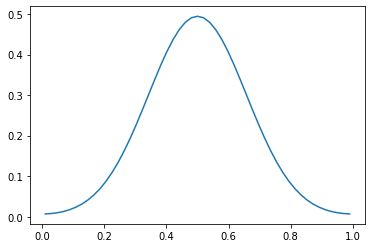

In [51]:
plt.plot(np.arange(a/2, 1 - a/2 + 1e-15, a), amez)

## Analytical Solution of the 1D Unsteady Diffusion Equatio

(from : https://ocw.mit.edu/courses/mathematics/18-303-linear-partial-differential-equations-fall-2006/lecture-notes/heateqni.pdf)

To solve an equation of the form

$$ \frac{\partial}{\partial t} c(x, t) = D \frac{d^2}{d x^2} c(x, t) $$ for diffusion constant $D$

Then, the solution (obtained via Fourier analysis) becomes

$$ u(x,t) = \sum_{n = 1}^\infty B_n \, sin(n \pi x) \, e^{-k n^2 \pi^2 t}$$

$$ B_n := 2 \int_0 ^1 sin(n \pi x) \, c(x, 0) \, dx$$


To construct the analytical solution, we will use the first 100 terms of the series and use numerical quadrature to solve for the $B_n$s. 

**Note :** We will use Gauss-Legendre quadrature as the quadrature degree can be increased with ease. Can use both `scipy.integrate.leggauss()` or the `gauss_legendre()` function from ACSE 3, Lecture 2...

**Note :** Having the simulation length of the problem (domain) be $\in [0, 1]$ allows us to continue using the dimensionless length of $1$. 

<br>

**NOTE :** First, we will use an initial condition of $c(x, 0) = f(x) = 6 sin \left( \frac{\pi x}{L} \right)$ ($L = 1$ for us) that yields the solution

$$ c(x, t) = 6 sin \left( \frac{\pi x}{L} \right) exp \left( - D \left( \frac{\pi }{L} \right)^2 t \right) $$

This should be more reliable as it does not require numerical integration, thereby bypassing the errors associated to numerical integration. (from : https://tutorial.math.lamar.edu/classes/de/solvingheatequation.aspx)

<br>



**Note :** Actual version when $L \neq 1$

$$ c(x,t) = \sum_{n = 1}^\infty B_n \, sin \left(\frac{n \pi x}{L} \right) \, e^{-D \left( \frac{n \pi}{L} \right)^2 t}$$

$$ B_n := \frac{2}{L} \int_0 ^L sin \left(\frac{n \pi x}{L} \right) \, c(x, 0) \, dx$$







# From Prof. Horsfield's notes:

For an average initial concentration $\bar{c}$, the analytical equation is given by:

$$ c(x, t) = \frac{\bar{c} L}{\sqrt{4 \pi D t}} exp \left( - \frac{x^2}{4 D t} \right) $$

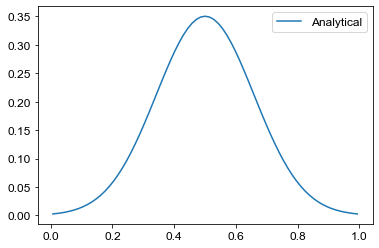

In [316]:
def diffusion_1D_analytical(Na, t, D = 0.01, n_i_amp = 10.0):
    
    a = 1.0/Na # dx
    x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
    L = x_ar[-1] - x_ar[0]
    
    n_Analytical = np.zeros((Na, 1))
    
    n_i_avg = n_i_amp/Na
    
    for i in range(len(x_ar)):
        
        n_Analytical[i] = (n_i_avg * L / np.sqrt(4 * np.pi * D * t)) * np.exp(-(x_ar[i]-0.5)**2 / (4 * D * t))
        
    return n_Analytical 


n_an = diffusion_1D_analytical(Na, 0.125, D = 0.1, n_i_amp = 10)
 
a = 1.0/Na # dx
x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
L = x_ar[-1] - x_ar[0]

plt.plot(x_ar, n_an)#, x_ar, amez)
plt.legend(['Analytical', 'CPFM'])




We will also use the RMS error


$$ \rVert \textbf{e}_{RMS} \rVert := \left( \dfrac{1}{N} \sum\limits^{N}_{i=1} |e_{i}|^2 \right) ^{1/2} $$


for the purposes of the error convergence analysis. We can then also add the $L_1$ and $L_2$ error norms to the analysis if needed. 

In [102]:
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation

from matplotlib import rcParams
# font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

In [239]:
def error_convergence_analysis(Na, dt, t_max):
    
    # we want Na to be odd so that we can populate the middle cell at index int((Na-1)/2)
    if (Na % 2 == 0):
        print('Na should be an odd number...')
        return 0
    
    else:
        a = 1.0/Na # dx
        x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
        
        # initialize initial condition
        n_alpha_IC = np.zeros((Na, 1))
        n_alpha_IC[int((Na-1)/2)] = 10.0 # initial concentration in middle cell
        
        # simulatio_1D inputs
        q_alpha = np.array([0])
        n_alpha_Update = np.zeros((Na,1))
        #n_alpha_Current = np.zeros((Ne,1))
        #n_alpha_Current[25] = 10
        n_alpha_Past = np.zeros((Na,1))
        n_alpha_Update = np.zeros((Na,1))
        mu_bar_alpha = np.zeros((Na,1)) #+ 1e-1
        D_alpha = 1e-1 * np.ones((Na,1))
        
        # CPFM solution @ time = t_max
        n_CPFM, t_finalized = simulation_1D(dt, t_max, Na, T, n_alpha_Update, n_alpha_IC, n_alpha_Past, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
        
        # analytical solution @ time = t_max
        n_analytical = diffusion_1D_analytical(Na, t_finalized, D = 0.1, n_i_amp = 10)
        
        # calculate the error
        e_rms = ((1.0/Na) * sum((n_analytical - n_CPFM)**2))**0.5
        
        return a, e_rms
    

## Error Convergence Analysis w.r.t. dx

The shape of B is (9, 9)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (19, 19)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (29, 29)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (39, 39)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (49, 49)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (59, 59)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (89, 89)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (119, 119)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (149, 149)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (189, 189)

Simulation completed at time 0.10000999999999392 !!!
The shape of B is (249, 249)

Simulation completed at time 0.10000999999999392 !!!


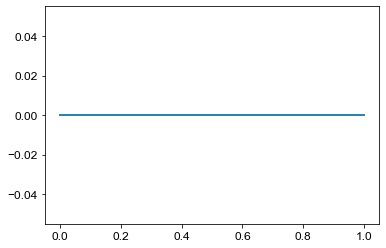

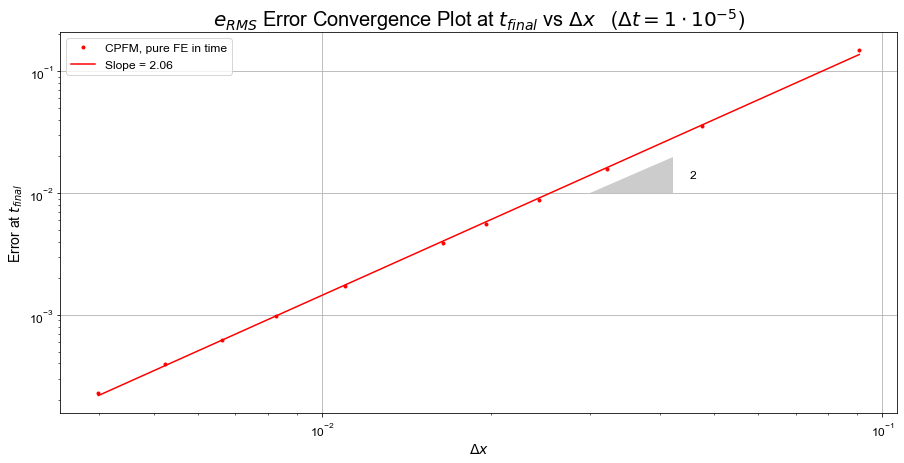

In [119]:
# Na values, where dx := 1/Na
Na_array = [11, 21, 31, 41, 51, 61, 91, 121, 151, 191, 251]

dt = 1e-5
t_max = 0.1

# dx values to be plotted
dx_array = []

# e_rms values to be plotted
e_rms_array = []

for Na in Na_array:
    
    a_temp, e_rms_temp = error_convergence_analysis(Na, dt, t_max)
    
    dx_array.append(a_temp)
    e_rms_array.append(e_rms_temp)

fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.loglog(dx_array, e_rms_array, 'r.', label='CPFM, pure FE in time')
ax1.set_xlabel('$\Delta x$', fontsize=14)
ax1.set_ylabel('Error at $t_{final}$', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

start_fit = 0

line_fit_CN = np.polyfit(np.log(dx_array[start_fit:]), np.log(e_rms_array[start_fit:]), 1)

ax1.loglog(dx_array, np.exp(line_fit_CN[1]) * dx_array**(line_fit_CN[0]), 'r-', label = list(map('Slope = {:.2f}'.format, line_fit_CN[0]))[0])
           # label = ('slope: {:.2f}'.format, line_fit_CN[0]))

plt.title(r"$e_{RMS}$ Error Convergence Plot at $t_{final}$ vs $\Delta x$   ($\Delta t = 1 \cdot 10^{-5}$)", fontsize=20)

ax1.legend(loc='best')

annotation.slope_marker((0.03, 0.01), 2, ax=ax1)


## Error Convergence Analysis w.r.t. dt

**r stability:** $$ r_c := \frac{D \Delta t}{\Delta x^2} < \frac{1}{2} \implies \Delta t < \frac{\Delta x^2}{2 D} $$

For $D = 0.1$, the condition then becomes $$ \Delta t < 5 \Delta x^2 $$

We need to make sure that for our fixed $\Delta x$ we vary $\Delta t$ such that r stability is consistently satisfied.

In [177]:
dt = 0.002

Na = 51

a = 1.0/51

while (dt > 1e-4):
    
    if (dt < 5 * a**2):
        
        print('r stability satisfied for dt =', dt, '. Room for error is ', (5 * a**2 - dt))
        
    else:
         print('r stability NOT satisfied for dt =', dt)
            
    dt *= 0.9
        

r stability NOT satisfied for dt = 0.002
r stability satisfied for dt = 0.0018000000000000002 . Room for error is  0.00012233756247597067
r stability satisfied for dt = 0.0016200000000000001 . Room for error is  0.0003023375624759707
r stability satisfied for dt = 0.001458 . Room for error is  0.00046433756247597074
r stability satisfied for dt = 0.0013122000000000001 . Room for error is  0.0006101375624759707
r stability satisfied for dt = 0.00118098 . Room for error is  0.0007413575624759707
r stability satisfied for dt = 0.001062882 . Room for error is  0.0008594555624759708
r stability satisfied for dt = 0.0009565938 . Room for error is  0.0009657437624759708
r stability satisfied for dt = 0.00086093442 . Room for error is  0.001061403142475971
r stability satisfied for dt = 0.000774840978 . Room for error is  0.0011474965844759707
r stability satisfied for dt = 0.0006973568802 . Room for error is  0.0012249806822759708
r stability satisfied for dt = 0.0006276211921800001 . Room fo


Simulation completed at time 0.10000000000000007 !!!

Simulation completed at time 0.10194900000000003 !!!

Simulation completed at time 0.10189802549999999 !!!

Simulation completed at time 0.10184707648725012 !!!

Simulation completed at time 0.10179615294900643 !!!

Simulation completed at time 0.10174525487253203 !!!

Simulation completed at time 0.10169438224509576 !!!

Simulation completed at time 0.10164353505397308 !!!

Simulation completed at time 0.10159271328644612 !!!

Simulation completed at time 0.10154191692980281 !!!

Simulation completed at time 0.10149114597133796 !!!

Simulation completed at time 0.10144040039835227 !!!

Simulation completed at time 0.10138968019815309 !!!

Simulation completed at time 0.1013389853580542 !!!

Simulation completed at time 0.10128831586537514 !!!

Simulation completed at time 0.10123767170744237 !!!

Simulation completed at time 0.10118705287158872 !!!

Simulation completed at time 0.10113645934515282 !!!

Simulation completed at time


Simulation completed at time 0.10004420074152459 !!!

Simulation completed at time 0.10184592269006411 !!!

Simulation completed at time 0.10179499972871911 !!!

Simulation completed at time 0.10174410222885477 !!!

Simulation completed at time 0.10169323017774025 !!!

Simulation completed at time 0.10164238356265154 !!!

Simulation completed at time 0.10159156237087028 !!!

Simulation completed at time 0.10154076658968483 !!!

Simulation completed at time 0.10148999620638988 !!!

Simulation completed at time 0.10143925120828681 !!!

Simulation completed at time 0.1013885315826825 !!!

Simulation completed at time 0.10133783731689124 !!!

Simulation completed at time 0.10128716839823282 !!!

Simulation completed at time 0.1012365248140336 !!!

Simulation completed at time 0.10118590655162679 !!!

Simulation completed at time 0.101135313598351 !!!

Simulation completed at time 0.10108474594155187 !!!

Simulation completed at time 0.10103420356858102 !!!

Simulation completed at time 0.


Simulation completed at time 0.10125543278782898 !!!

Simulation completed at time 0.1012048050714351 !!!

Simulation completed at time 0.1011542026688995 !!!

Simulation completed at time 0.10110362556756505 !!!

Simulation completed at time 0.10105307375478129 !!!

Simulation completed at time 0.10100254721790394 !!!

Simulation completed at time 0.10095204594429498 !!!

Simulation completed at time 0.10090156992132265 !!!

Simulation completed at time 0.10085111913636215 !!!

Simulation completed at time 0.10080069357679382 !!!

Simulation completed at time 0.10075029323000555 !!!

Simulation completed at time 0.10069991808339043 !!!

Simulation completed at time 0.10064956812434869 !!!

Simulation completed at time 0.10059924334028658 !!!

Simulation completed at time 0.10054894371861643 !!!

Simulation completed at time 0.10049866924675722 !!!

Simulation completed at time 0.10044841991213385 !!!

Simulation completed at time 0.10039819570217783 !!!

Simulation completed at time 


Simulation completed at time 0.10010547576555752 !!!

Simulation completed at time 0.10005542302767481 !!!

Simulation completed at time 0.10000539531616104 !!!

Simulation completed at time 0.10154198615212985 !!!

Simulation completed at time 0.10149121515905372 !!!

Simulation completed at time 0.10144046955147433 !!!

Simulation completed at time 0.10138974931669863 !!!

Simulation completed at time 0.10133905444204028 !!!

Simulation completed at time 0.10128838491481933 !!!

Simulation completed at time 0.10123774072236186 !!!

Simulation completed at time 0.10118712185200064 !!!

Simulation completed at time 0.10113652829107454 !!!

Simulation completed at time 0.10108596002692916 !!!

Simulation completed at time 0.10103541704691564 !!!

Simulation completed at time 0.10098489933839234 !!!

Simulation completed at time 0.10093440688872303 !!!

Simulation completed at time 0.10088393968527855 !!!

Simulation completed at time 0.10083349771543593 !!!

Simulation completed at tim

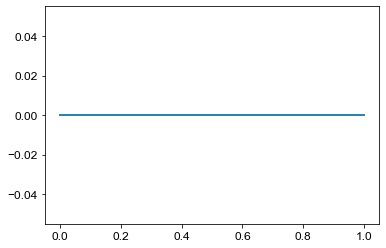

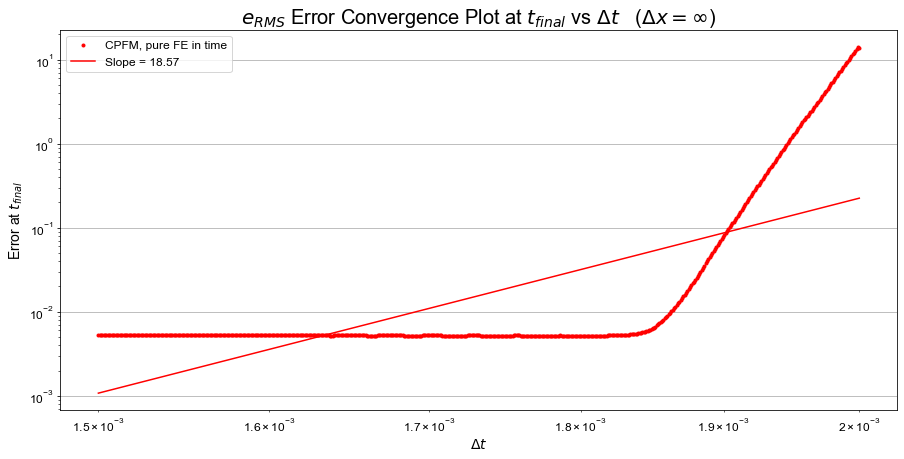

In [241]:
Na = 51

dt = 0.002
t_max = 0.1

# dx values to be plotted
dt_array = []

# e_rms values to be plotted
e_rms_array = []

while (dt > 1.5e-3):
    
    a_temp, e_rms_temp = error_convergence_analysis(Na, dt, t_max)
    
    dt_array.append(dt)
    e_rms_array.append(e_rms_temp)
    
    dt *= 0.999

fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.loglog(dt_array, e_rms_array, 'r.', label='CPFM, pure FE in time')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t_{final}$', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

start_fit = 0

line_fit_CN = np.polyfit(np.log(dt_array[start_fit:]), np.log(e_rms_array[start_fit:]), 1)

ax1.loglog(dt_array, np.exp(line_fit_CN[1]) * dt_array**(line_fit_CN[0]), 'r-', label = list(map('Slope = {:.2f}'.format, line_fit_CN[0]))[0])
           # label = ('slope: {:.2f}'.format, line_fit_CN[0]))

plt.title(r"$e_{RMS}$ Error Convergence Plot at $t_{final}$ vs $\Delta t$   ($\Delta x = \infty$)", fontsize=20)

ax1.legend(loc='best')

#annotation.slope_marker((0.03, 0.01), 2, ax=ax1)



In [202]:
arr_dt = np.linspace(2.0, 3.0, 25)
arr_dt = 1**(-arr_dt)
arr_dt

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [297]:
def error_convergence_analysis(Na, dt, t_max):
    
    # we want Na to be odd so that we can populate the middle cell at index int((Na-1)/2)
    if (Na % 2 == 0):
        print('Na should be an odd number...')
        return 0
    
    else:
        a = 1.0/Na # dx
        x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
        
        # initialize initial condition
        n_alpha_IC = np.zeros((Na, 1))
        n_alpha_IC[int((Na-1)/2)] = 10.0 # initial concentration in middle cell
        
        # simulatio_1D inputs
        q_alpha = np.array([0])
        n_alpha_Update = np.zeros((Na,1))
        #n_alpha_Current = np.zeros((Ne,1))
        #n_alpha_Current[25] = 10
        n_alpha_Past = np.zeros((Na,1))
        n_alpha_Update = np.zeros((Na,1))
        mu_bar_alpha = np.zeros((Na,1)) #+ 1e-1
        D_alpha = 1e-3 * np.ones((Na,1))
        
        # CPFM solution @ time = t_max
        n_CPFM, t_finalized = simulation_1D(dt, t_max, Na, T, n_alpha_Update, n_alpha_IC, n_alpha_Past, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
        
        # analytical solution @ time = t_max
        n_analytical = diffusion_1D_analytical(Na, t_finalized, D = D_alpha[1], n_i_amp = 10)
        
        # calculate the error
        e_rms = ((1.0/Na) * sum((n_analytical - n_CPFM)**2))**0.5
        
        return a, e_rms
    


Simulation completed at time 0.9330329915368074 !!!

Simulation completed at time 0.7755723809168673 !!!

Simulation completed at time 0.6446851542197896 !!!

Simulation completed at time 0.5358867312681466 !!!

Simulation completed at time 0.44544935907016964 !!!

Simulation completed at time 0.37027438807164104 !!!

Simulation completed at time 0.307786103336229 !!!

Simulation completed at time 0.2558434729991937 !!!

Simulation completed at time 0.21266679023771393 !!!

Simulation completed at time 0.1767766952966369 !!!


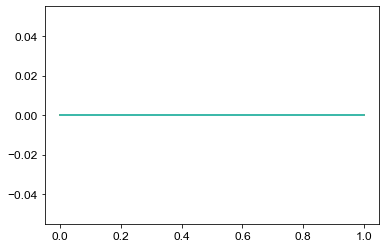

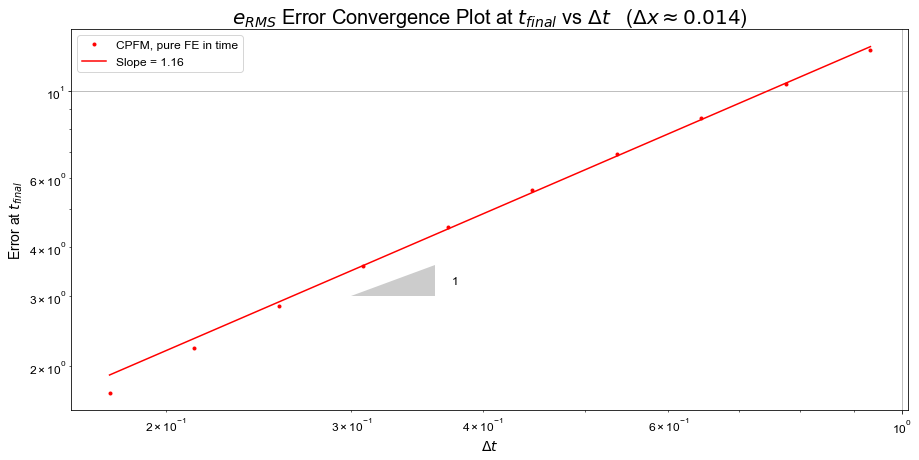

In [314]:
arr_dt = np.linspace(0.1, 2.5, 10)

Na = 71

t_max = 0.01

# dx values to be plotted
dt_array = []

# e_rms values to be plotted
e_rms_array = []

for dt in arr_dt:
    
    dt = 2.0**(-dt)
    
    a_temp, e_rms_temp = error_convergence_analysis(Na, dt, t_max)
    
    dt_array.append(dt)
    e_rms_array.append(e_rms_temp)
    
fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.loglog(dt_array, e_rms_array, 'r.', label='CPFM, pure FE in time')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t_{final}$', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

start_fit = 0
end_fit = len(dt_array) - 2

line_fit_CN = np.polyfit(np.log(dt_array[start_fit:end_fit]), np.log(e_rms_array[start_fit:end_fit]), 1)

ax1.loglog(dt_array, np.exp(line_fit_CN[1]) * dt_array**(line_fit_CN[0]), 'r-', label = list(map('Slope = {:.2f}'.format, line_fit_CN[0]))[0])
           # label = ('slope: {:.2f}'.format, line_fit_CN[0]))

plt.title(r"$e_{RMS}$ Error Convergence Plot at $t_{final}$ vs $\Delta t$   ($\Delta x \approx 0.014 $)", fontsize=20)

ax1.legend(loc='best')

annotation.slope_marker((0.3, 3), 1, ax=ax1)




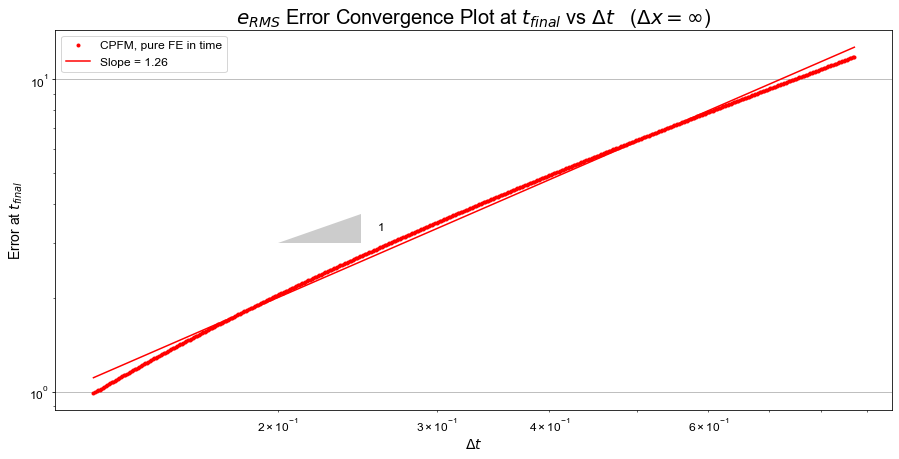

In [305]:
# Na = 51

fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.loglog(dt_array, e_rms_array, 'r.', label='CPFM, pure FE in time')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t_{final}$', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

start_fit = 0
end_fit = 1500

line_fit_CN = np.polyfit(np.log(dt_array[start_fit:end_fit]), np.log(e_rms_array[start_fit:end_fit]), 1)

ax1.loglog(dt_array, np.exp(line_fit_CN[1]) * dt_array**(line_fit_CN[0]), 'r-', label = list(map('Slope = {:.2f}'.format, line_fit_CN[0]))[0])
           # label = ('slope: {:.2f}'.format, line_fit_CN[0]))

plt.title(r"$e_{RMS}$ Error Convergence Plot at $t_{final}$ vs $\Delta t$   ($\Delta x = \infty$)", fontsize=20)

ax1.legend(loc='best')

annotation.slope_marker((0.2, 3), 1, ax=ax1)

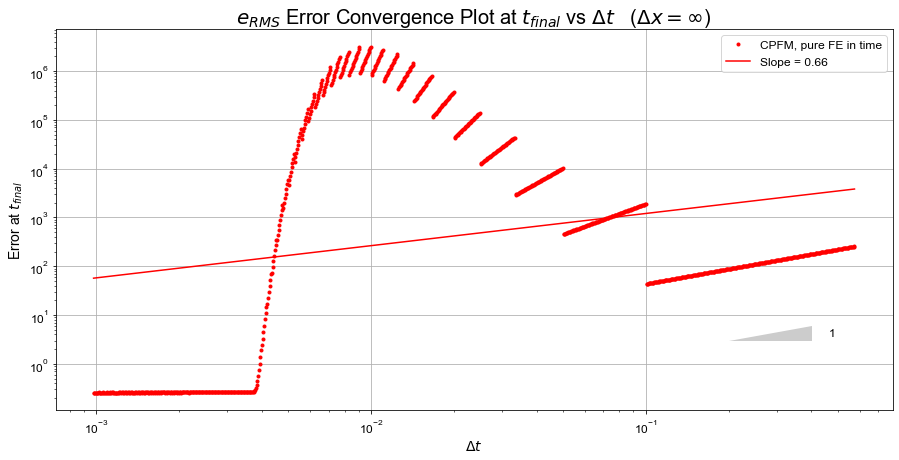

In [288]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.loglog(dt_array, e_rms_array, 'r.', label='CPFM, pure FE in time')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t_{final}$', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

start_fit = 0
end_fit = 1500

line_fit_CN = np.polyfit(np.log(dt_array[start_fit:end_fit]), np.log(e_rms_array[start_fit:end_fit]), 1)

ax1.loglog(dt_array, np.exp(line_fit_CN[1]) * dt_array**(line_fit_CN[0]), 'r-', label = list(map('Slope = {:.2f}'.format, line_fit_CN[0]))[0])
           # label = ('slope: {:.2f}'.format, line_fit_CN[0]))

plt.title(r"$e_{RMS}$ Error Convergence Plot at $t_{final}$ vs $\Delta t$   ($\Delta x = \infty$)", fontsize=20)

ax1.legend(loc='best')

annotation.slope_marker((0.2, 3), 1, ax=ax1)

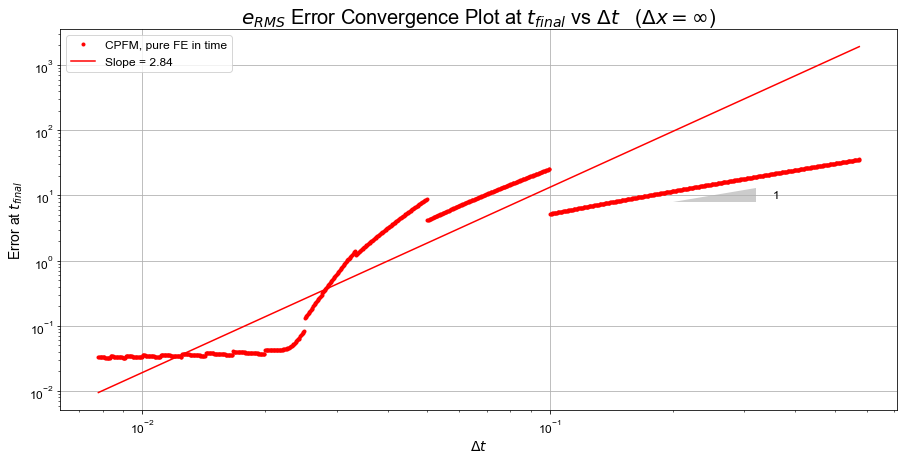

In [277]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.loglog(dt_array, e_rms_array, 'r.', label='CPFM, pure FE in time')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t_{final}$', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

start_fit = 600
end_fit = 999

line_fit_CN = np.polyfit(np.log(dt_array[start_fit:end_fit]), np.log(e_rms_array[start_fit:end_fit]), 1)

ax1.loglog(dt_array, np.exp(line_fit_CN[1]) * dt_array**(line_fit_CN[0]), 'r-', label = list(map('Slope = {:.2f}'.format, line_fit_CN[0]))[0])
           # label = ('slope: {:.2f}'.format, line_fit_CN[0]))

plt.title(r"$e_{RMS}$ Error Convergence Plot at $t_{final}$ vs $\Delta t$   ($\Delta x = \infty$)", fontsize=20)

ax1.legend(loc='best')

annotation.slope_marker((0.2, 8), 1, ax=ax1)

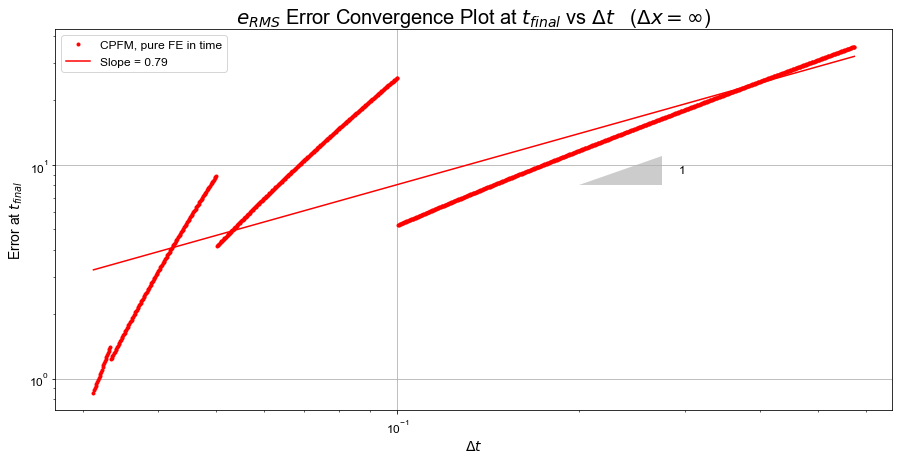

In [271]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.loglog(dt_array, e_rms_array, 'r.', label='CPFM, pure FE in time')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t_{final}$', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

start_fit = 0
end_fit = 1500

line_fit_CN = np.polyfit(np.log(dt_array[start_fit:end_fit]), np.log(e_rms_array[start_fit:end_fit]), 1)

ax1.loglog(dt_array, np.exp(line_fit_CN[1]) * dt_array**(line_fit_CN[0]), 'r-', label = list(map('Slope = {:.2f}'.format, line_fit_CN[0]))[0])
           # label = ('slope: {:.2f}'.format, line_fit_CN[0]))

plt.title(r"$e_{RMS}$ Error Convergence Plot at $t_{final}$ vs $\Delta t$   ($\Delta x = \infty$)", fontsize=20)

ax1.legend(loc='best')

annotation.slope_marker((0.2, 8), 1, ax=ax1)

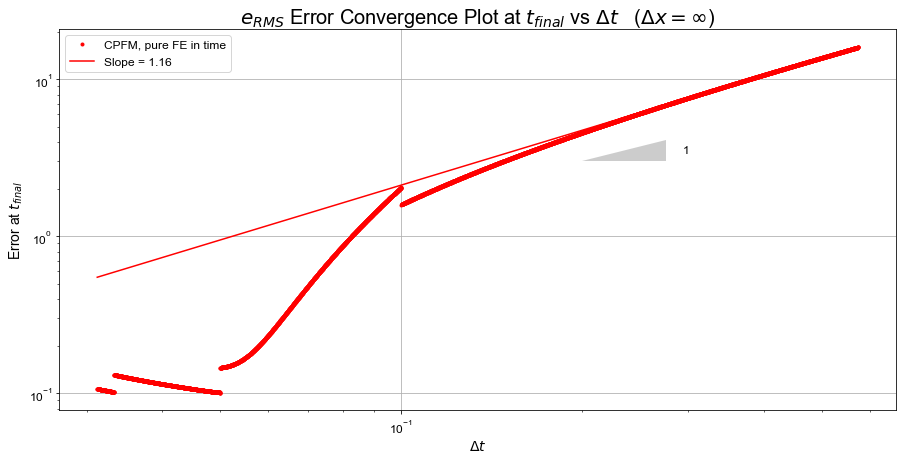

In [267]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 7))
ax1.loglog(dt_array, e_rms_array, 'r.', label='CPFM, pure FE in time')
ax1.set_xlabel('$\Delta t$', fontsize=14)
ax1.set_ylabel('Error at $t_{final}$', fontsize=14)
ax1.grid(True)

# use numpy.polyfit to find best fit linear line to data

start_fit = 0
end_fit = 1500

line_fit_CN = np.polyfit(np.log(dt_array[start_fit:end_fit]), np.log(e_rms_array[start_fit:end_fit]), 1)

ax1.loglog(dt_array, np.exp(line_fit_CN[1]) * dt_array**(line_fit_CN[0]), 'r-', label = list(map('Slope = {:.2f}'.format, line_fit_CN[0]))[0])
           # label = ('slope: {:.2f}'.format, line_fit_CN[0]))

plt.title(r"$e_{RMS}$ Error Convergence Plot at $t_{final}$ vs $\Delta t$   ($\Delta x = \infty$)", fontsize=20)

ax1.legend(loc='best')

annotation.slope_marker((0.2, 3), 1, ax=ax1)


In [159]:
a = 1.0/101

5 * a**2 

0.0004901480247034605

The shape of B is (99, 99)

Simulation completed at time 0.10039499999999987 !!!


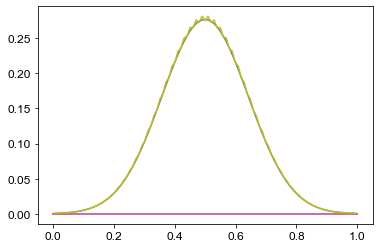

In [163]:
dt = 0.000485

Na = 101

a = 1.0/Na # dx
x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 

# initialize initial condition
n_alpha_IC = np.zeros((Na, 1))
n_alpha_IC[int((Na-1)/2)] = 10.0 # initial concentration in middle cell
        
# simulatio_1D inputs
q_alpha = np.array([0])
n_alpha_Update = np.zeros((Na,1))
#n_alpha_Current = np.zeros((Ne,1))
#n_alpha_Current[25] = 10
n_alpha_Past = np.zeros((Na,1))
n_alpha_Update = np.zeros((Na,1))
mu_bar_alpha = np.zeros((Na,1)) #+ 1e-1
D_alpha = 1e-1 * np.ones((Na,1))
 
# analytical solution @ time = t_max
n_analytical = diffusion_1D_analytical(Na, t_max, D = 0.1, n_i_amp = 10)
        
# CPFM solution @ time = t_max
n_CPFM = simulation_1D(dt, t_max, Na, T, n_alpha_Update, n_alpha_IC, n_alpha_Past, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
        
    
plt.plot(x_ar, n_analytical, x_ar, n_CPFM)

The shape of B is (999, 999)


<ipython-input-87-e8e561e5c4e6>:77: RuntimeWarning: overflow encountered in double_scalars
  J_2 = np.exp(-(mu_alpha[i+1][alpha] + mu_alpha[i][alpha]) / (2 * k_B * T)) * (v_alpha[i][alpha] * n_alpha[i][alpha] * np.exp(mu_alpha[i][alpha]/(k_B * T))
<ipython-input-87-e8e561e5c4e6>:69: RuntimeWarning: overflow encountered in double_scalars
  J_1 = np.exp(-(mu_alpha[i][alpha] + mu_alpha[i-1][alpha]) / (2 * k_B * T)) * (v_alpha[i-1][alpha] * n_alpha[i-1][alpha] * np.exp(mu_alpha[i-1][alpha]/(k_B * T))
<ipython-input-87-e8e561e5c4e6>:78: RuntimeWarning: overflow encountered in double_scalars
  - v_alpha[i+1][alpha] * n_alpha[i+1][alpha] * np.exp(mu_alpha[i+1][alpha]/(k_B * T)))
<ipython-input-87-e8e561e5c4e6>:70: RuntimeWarning: overflow encountered in double_scalars
  - v_alpha[i][alpha] * n_alpha[i][alpha] * np.exp(mu_alpha[i][alpha]/(k_B * T)))
<ipython-input-90-b6a0368956aa>:24: RuntimeWarning: overflow encountered in double_scalars
  n_alpha_Update[i][alpha] = n_alpha_Current[i][alpha] 

KeyboardInterrupt: 

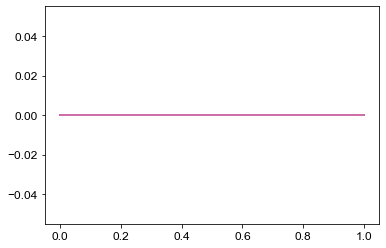

In [133]:
dt = 0.00008

Na = 1001

a = 1.0/Na # dx
x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 

# initialize initial condition
n_alpha_IC = np.zeros((Na, 1))
n_alpha_IC[int((Na-1)/2)] = 10.0 # initial concentration in middle cell
        
# simulatio_1D inputs
q_alpha = np.array([0])
n_alpha_Update = np.zeros((Na,1))
#n_alpha_Current = np.zeros((Ne,1))
#n_alpha_Current[25] = 10
n_alpha_Past = np.zeros((Na,1))
n_alpha_Update = np.zeros((Na,1))
mu_bar_alpha = np.zeros((Na,1)) #+ 1e-1
D_alpha = 1e-1 * np.ones((Na,1))
 
# analytical solution @ time = t_max
n_analytical = diffusion_1D_analytical(Na, t_max, D = 0.1, n_i_amp = 10)
        
# CPFM solution @ time = t_max
n_CPFM = simulation_1D(dt, t_max, Na, T, n_alpha_Update, n_alpha_IC, n_alpha_Past, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
        
    
plt.plot(x_ar, n_analytical, x_ar, n_CPFM)

In [ ]:
a = 1.0/Na # dx
x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
    
L = x_ar[-1] - x_ar[0]



n_alpha_IC = np.zeros((Ne, 1))
n_alpha_IC[25] = 10
a = 1.0/Ne
x_arr = np.arange(a/2, 1 - a/2 + 1e-15, a)
L = x_ar[-1] - x_ar[0]



"""
def f(x, x_ic, n):
    
    b_n = (2.0/L) * np.sin(x * np.pi * n / L) * x_ic
    
    print(b_n)
    
    return b_n
"""     
    

In [ ]:
"""
def Bn_gauss_legendre(Na, n, n_alpha_IC, degree=51):
    #Function to evaluate Gauss Legendre quadrature
    
    a = 1.0/Na # dx
    x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
    L = x_ar[len(x_ar)-1] - x_ar[0]
    
    # integration limits
    a_lim = x_ar[0]
    b_lim = x_ar[len(x_ar)-1]

    # compute the Gauss-Legendre nodes and weights
    xi, w = np.polynomial.legendre.leggauss(degree)

    # Translate the node locations from the interval [-1, 1] to [a, b]
    x =  0.5*(b_lim + a_lim) + 0.5 * (b_lim - a_lim) * xi
    
    B_n = (2.0/L) * np.sin(x_ar * np.pi * n / L) @ n_alpha_IC
    
    print(np.shape(x_ar))
 
    return 0.5*(b_lim - a_lim) * sum(w * B_n)
"""


In [ ]:
"""
def diffusion_1D_analytical(Na, t, n_alpha_IC, D = 0.1, sum_limit = 10):
    
    a = 1.0/Na # dx
    x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
    L = x_ar[len(x_ar)-1] - x_ar[0]
    
    n_Analytical = np.zeros((Na, 1)) # initialize solution
    
    for n in range(sum_limit):
        
        b_n = Bn_gauss_legendre(Na, n, n_alpha_IC, degree=51)
        
        print(np.shape(b_n))
        print(np.shape(x_ar))
        print(np.shape(np.sin(n * np.pi * x_ar / L)))
        print(np.shape(np.exp(-D * n**2 * np.pi**2 * t / L)))
        print(np.shape(b_n))
        
        n_Analytical += b_n * np.exp(-D * n**2 * np.pi**2 * t / L) * np.sin(n * np.pi * x_ar / L)
        
    return n_Analytical
"""    

In [ ]:
I_gl =  Bn_gauss_legendre(Na, 1, n_alpha_IC, degree=51)

In [ ]:
I_gl

In [ ]:

#def gauss_legendre(a, b, function, degree=5):

    #Function to evaluate Gauss Legendre quadrature

    # compute the Gauss-Legendre nodes and weights
    #xi, w = np.polynomial.legendre.leggauss(degree)

    # Translate the node locations from the interval [-1, 1] to [a, b]
    #x =  0.5*(b + a) + 0.5 * (b - a) * xi
 
    #return 0.5*(b - a) * sum(w * f(x))

In [ ]:
"""
def diffusion_eqn_1D_specific(x, t, D, Na):
    # solves for the above problem, example a) from : https://tutorial.math.lamar.edu/classes/de/solvingheatequation.aspx
    
    a = 1.0/Na # dx
    x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
    
    L = x_ar[-1] - x_ar[0] # calculate the endpoints to find the real length
    
    return 6 * np.sin(np.pi * x / L) * np.exp(-D * t * np.pi**2 / L**2)
    
    
def IC_1D_specific(Na):
    # creates the specific IC, example a) from : https://tutorial.math.lamar.edu/classes/de/solvingheatequation.aspx
    
    a = 1.0/Na # dx
    x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a) # identical to B_x 
    
    L = x_ar[-1] - x_ar[0] # calculate the endpoints to find the real length
    
    n_alpha_Current = np.zeros((Na,1))
    
    for i in range(Na):
        
        n_alpha_Current[i] = 6 * np.sin(np.pi * x_ar[i] / L)
        
    return n_alpha_Current
"""    

In [ ]:
"""
x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a)

y_ar = diffusion_eqn_1D_specific(x_ar, 0.5, 0.1, Ne)

plt.plot(x_ar, y_ar)
"""

In [ ]:
"""
x_ar = np.arange(a/2, 1 - a/2 + 1e-15, a)

y_ar = IC_1D_specific(Ne)

plt.plot(x_ar, y_ar)
"""

In [ ]:
import scipy.integrate as si

def f(x, n, ):
    """The function we wish to integrate"""
    return np.sin(x)

# interval to integrate over
a = 0.0
b = np.pi

def gauss_legendre(a, b, function, degree=5):
    """Function to evaluate Gauss Legendre quadrature
    """
    # compute the Gauss-Legendre nodes and weights
    xi, w = np.polynomial.legendre.leggauss(degree)

    # Translate the node locations from the interval [-1, 1] to [a, b]
    x =  0.5*(b + a) + 0.5 * (b - a) * xi
 
    return 0.5*(b - a) * sum(w * f(x))


degrees = np.linspace(1, 15 , 6, dtype=int)
for degree in degrees:
    I_gl =  gauss_legendre(a, b, f, degree)
    I_sigl = si.fixed_quad(f, a, b, n=degree)[0]
    print('Integrals from our code and SciPy for degree {0} = {1}, {2}'.format(degree,I_gl,I_sigl))



In [ ]:
from matplotlib.animation import FuncAnimation 
from matplotlib import animation

In [ ]:
A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na

In [321]:
def plotter(x, y):
    
    return plt.plot(x, y)

xab = np.linspace(0, 1, 5)
yab = np.linspace(0, 2, 5)

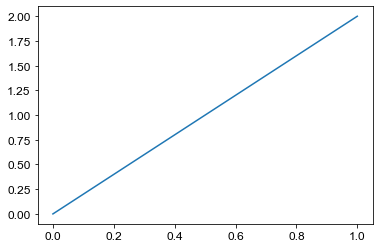

In [322]:
plotter(xab, yab)

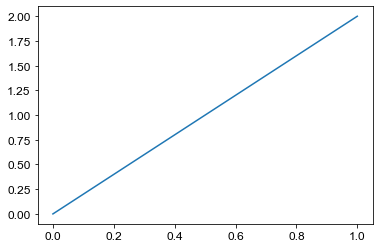

In [323]:
aplots = plotter(xab, yab)